# Reduced Gravity

## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

Plot utils

In [4]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits.axes_grid1 import make_axes_locatable

from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-25, h_max=0, 
                 uv_min=-0.3, uv_max=0.3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    huv_label = ["hu","hv"]
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        uv_min = -0.3
        uv_max = +0.3
        huv_label = ["u","v"]

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots

        uv_cmap = plt.cm.coolwarm
        uv_cmap.set_bad("grey", alpha = 1.0)
        
        h_cmap = plt.cm.Blues_r
        h_cmap.set_bad("grey", alpha = 1.0)

        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(-h, interpolation="none", origin='lower', 
                             cmap=h_cmap, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$\zeta{}$")
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[0],cax=cax0)


        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=uv_cmap, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[0]+"$")
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[1],cax=cax1)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=uv_cmap, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[1]+"$")
        divider2 = make_axes_locatable(ax[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[2],cax=cax2)

        plt.tight_layout()
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(-h)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(24, 4))

    try:
        ncfile = Dataset(filename)
        try:
            x = ncfile.variables['x'][:]
        except:
            x = ncfile.variables['X'][x0:x1]
        try:
            y = ncfile.variables['y'][:]
        except:
            y = ncfile.variables['Y'][y0:y1]
        t = ncfile.variables['time'][:]

        try:
            H_m = ncfile.variables['Hm'][:,:]
        except:
            H_m = ncfile.variables['h'][y0:y1,x0:x1]
        try:
            eta = ncfile.variables['eta'][:,:,:]
        except:
            eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
        try:
            hu = ncfile.variables['hu'][:,:,:]
            calc_uv = True
        except:
            if reduced_gravity_interface is None:
                hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                calc_uv = False
            else:
                if reduced_gravity_interface > 0.0:
                    hu = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                    calc_uv = True
                else:
                    hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                    calc_uv = False
        try:
            hv = ncfile.variables['hv'][:,:,:]
        except:
            if reduced_gravity_interface is None:
                hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
            else:
                if reduced_gravity_interface > 0.0:
                    hv = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                else:
                    hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
                    
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], "Initalised from Mixed Layer Daily-Average",
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        (1-s)*eta[j] + s*eta[k], 
                        (1-s)*hu[j]  + s*hu[k], 
                        (1-s)*hv[j]  + s*hv[k], 
                        H_m+(1-s)*eta[j] + s*eta[k], 
                        dx, dy, 
                        t_now, "Initalised from Mixed Layer Daily-Average",
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Selecting Area

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
casename = 'skagerrak'

from importlib import reload
from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)
case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'skagerrak'

In [6]:
locals().update(case_info)

## Construct initial conditions

In [7]:
#s_source_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"
s_source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/new_norkyst800m/avg/ocean_avg.an.20190716.nc"

In [8]:
from importlib import reload 
reload(NetCDFInitialization)
data_args = NetCDFInitialization.getInitialConditions(s_source_url, x0, x1, y0, y1, download_data=False, norkyst_data=False)
NetCDFInitialization.removeMetadata(data_args).keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind_stress'])

In [9]:
Hi = data_args["H"]

In [10]:
data_args["f"] = 1.2e-4
data_args["latitude"] = None

In [11]:
mld = NetCDFInitialization.fill_coastal_data(NetCDFInitialization.MLD(s_source_url, 1025, min_mld=5, max_mld=40, x0=x0-2, x1=x1+2, y0=y0-2, y1=y1+2))

In [ ]:
integrator = NetCDFInitialization.MLD_integrator(s_source_url, mld, x0=x0-2, x1=x1+2, y0=y0-2, y1=y1+2)

Calculate reduced gravity based on formula from Røed 

In [ ]:
s_pot_densities = NetCDFInitialization.potentialDensities(s_source_url, t=0, x0=x0-1, x1=x1+1, y0=y0-1, y1=y1+1)

ml_pot_density = np.average(np.sum(integrator[:,1:-1,1:-1] * s_pot_densities, axis=0)/np.sum(integrator[:,1:-1,1:-1], axis=0))

inverse_integrator = np.ma.array(np.ones_like(integrator), mask=integrator.mask.copy()) - integrator
deep_pot_density  = np.average(np.sum(inverse_integrator[:,1:-1,1:-1] * s_pot_densities, axis=0)/np.sum(inverse_integrator[:,1:-1,1:-1], axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

data_args["g"] = eps*data_args["g"] 

In [ ]:
data_args["g"]

0.013794060775166922

No bathymetry friction

In [ ]:
data_args["r"] = 0.0 

Constant reference bathymetry

In [ ]:
H = 5.0
data_args["H"] = np.ma.array(H*np.ones_like(data_args["H"]), mask=data_args["H"].mask.copy(), dtype=np.float32)

MLD as bathymetry

In [ ]:
data_args["eta0"] = np.ma.array(mld.data[2:-2,2:-2] - H, mask=mld[2:-2,2:-2].mask, dtype=np.float32)

Geostrophic balance

In [ ]:
dx_eta = np.ma.array(np.zeros((y1-y0+4,x1-x0+4)), mask=mld.mask.copy())
dy_eta = np.ma.array(np.zeros((y1-y0+4,x1-x0+4)), mask=mld.mask.copy())

In [ ]:
for i in range(1, x1-x0+1):
    for j in range(1, y1-y0+1):
        if mld.mask[j,i] == False:
            dx = 0
            if mld.mask[j,i+1] == False:
                x_up = mld[j,i+1]
                dx += 800
            else:
                x_up = mld[j,i]
            if mld.mask[j,i-1] == False:
                x_down = mld[j,i+-1]
                dx += 800
            else:
                x_down = mld[j,i]
            if dx != 0:
                dx_eta[j,i] = (x_up - x_down)/dx
            else: 
                dx_eta[j,i] = 0
                 
            dy = 0
            if mld.mask[j+1,i] == False:
                y_up = mld[j+1,i]
                dy += 800
            else:
                y_up = mld[j,i]
            if mld.mask[j-1,i] == False:
                y_down = mld[j-1,i]
                dy += 800
            else:
                y_down = mld[j,i]
            if dy != 0:
                dy_eta[j,i] = (y_up - y_down)/dy
            else: 
                dy_eta[j,i] = 0            

In [ ]:
for i in range(1, x1-x0+1):
    for j in range(1, y1-y0+1):
    
        dx_eta[j,i] = (mld[j,i+1] - mld[j,i-1])/1600
        dy_eta[j,i] = (mld[j+1,i] - mld[j-1,i])/1600


In [ ]:
hu = -data_args["g"]/data_args["f"] * mld[1:-1,1:-1] * dy_eta[1:-1,1:-1]
hv = data_args["g"]/data_args["f"] * mld[1:-1,1:-1] * dx_eta[1:-1,1:-1]  

In [ ]:
hu = np.ma.maximum(hu, -10)
hu = np.ma.minimum(hu, +10)

hv = np.ma.maximum(hv, -10)
hv = np.ma.minimum(hv, +10)

Initial momenta from geostroiphic balance

In [ ]:
data_args["hu0"] = hu[1:-1,1:-1]
data_args["hv0"] = hv[1:-1,1:-1]

Corresponding (constant) boundary conditions

In [ ]:
data_args["boundary_conditions_data"].north.h = np.array([mld[-2,2:-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].south.h = np.array([mld[1,2:-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].east.h = np.array([mld[2:-2,-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].west.h = np.array([mld[2:-2,1]-H], dtype=np.float32)

data_args["boundary_conditions_data"].north.hu = np.array([hu[-1,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].south.hu = np.array([hu[0,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].east.hu = np.array([hu[1:-1,-1]], dtype=np.float32)
data_args["boundary_conditions_data"].west.hu = np.array([hu[1:-1,0]], dtype=np.float32)

data_args["boundary_conditions_data"].north.hv = np.array([hv[-1,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].south.hv = np.array([hv[0,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].east.hv = np.array([hv[1:-1,-1]], dtype=np.float32)
data_args["boundary_conditions_data"].west.hv = np.array([hv[1:-1,0]], dtype=np.float32)

## Simulation

In [ ]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "write_netcdf":True
     }

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))


This will give inaccurate angle along the border!


In [ ]:
# for hour in range(24):
#     sim.step(3600.0, apply_stochastic_term=False)

In [ ]:
# anim = ncAnimation(sim.sim_writer.output_file_name)
# anim

In [ ]:
#sim.step(1)
eta, hu, hv = sim.download(interior_domain_only=True)

In [ ]:
from gpuocean.utils import OceanographicUtilities
Hm = OceanographicUtilities.intersectionsToMidpoints(Hi)

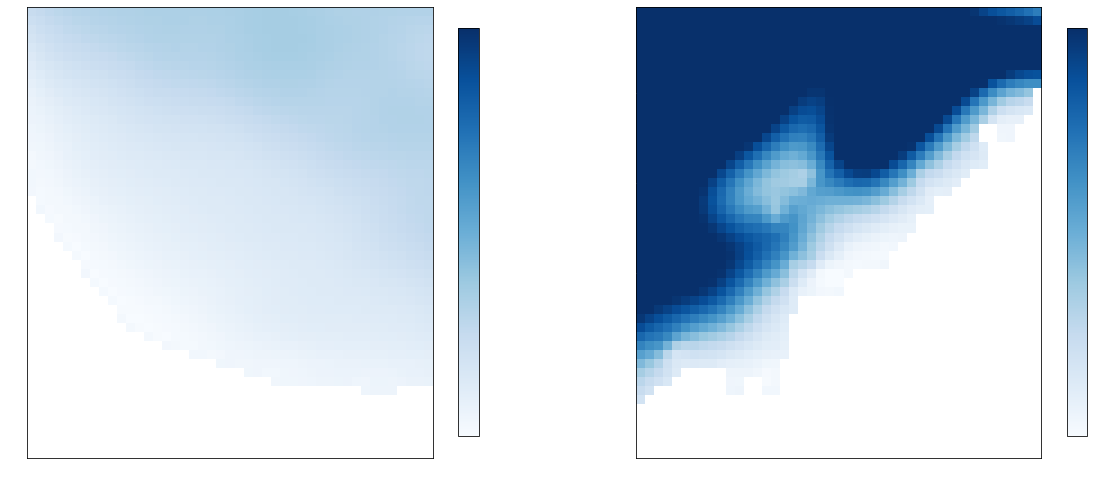

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(Hm[25:75,100:145], origin="lower", cmap="Blues", vmax=50)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(Hm[0:50,330:375], origin="lower", cmap="Blues", vmax=50)
plt.colorbar(im1, ax = axs[1], shrink=0.5)


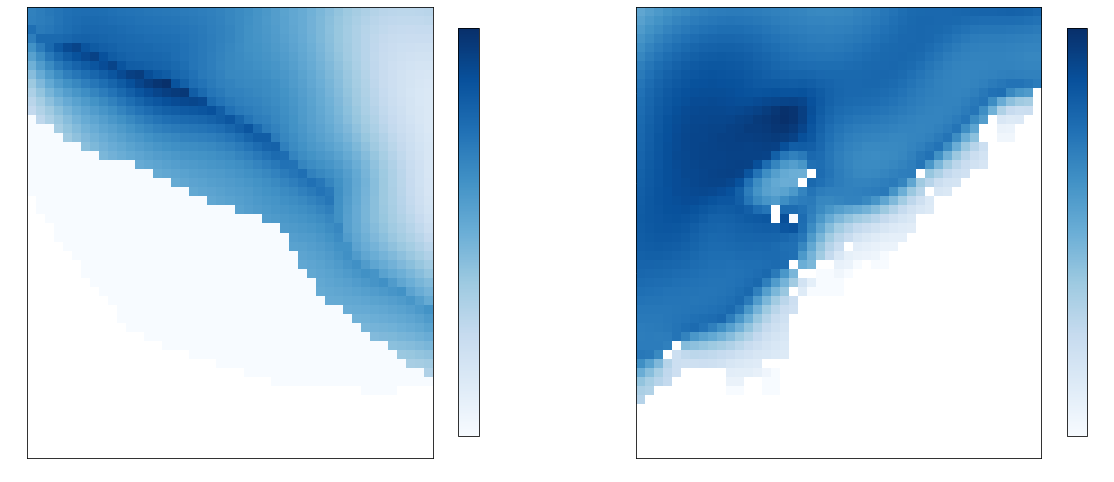

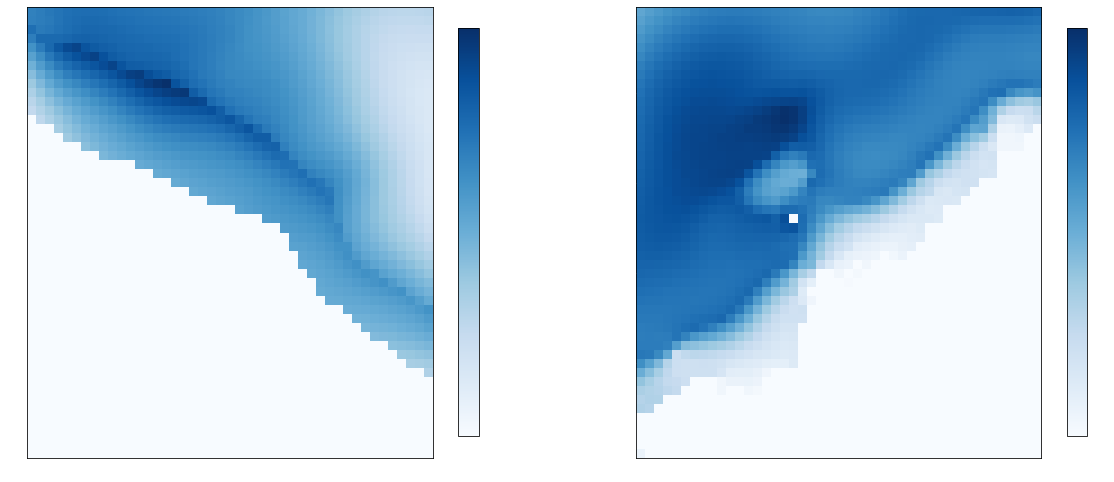

In [ ]:
arr = np.ma.array(mld.data[2:-2,2:-2] - 5, mask=mld[2:-2,2:-2].mask)

fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(arr[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(arr[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)


fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(arr.data[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(arr.data[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)

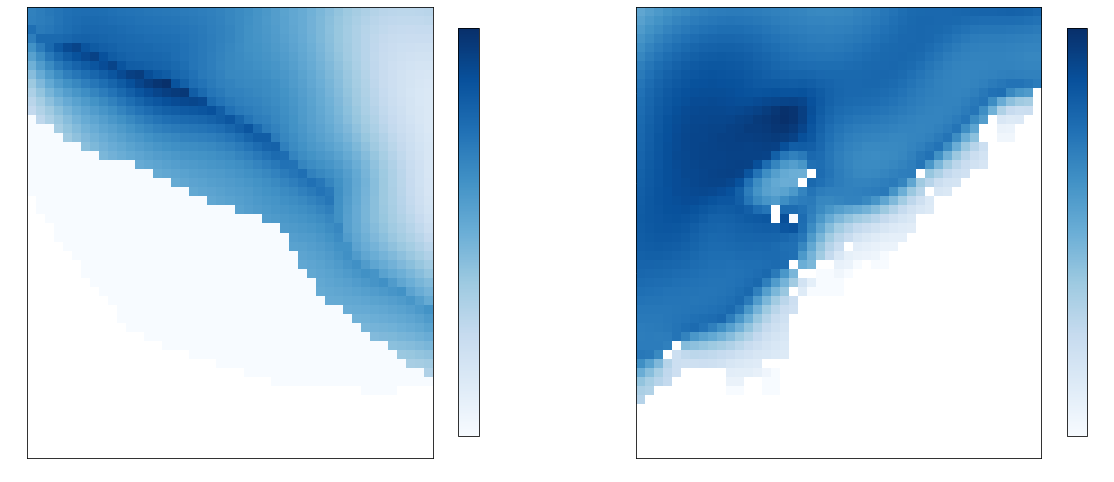

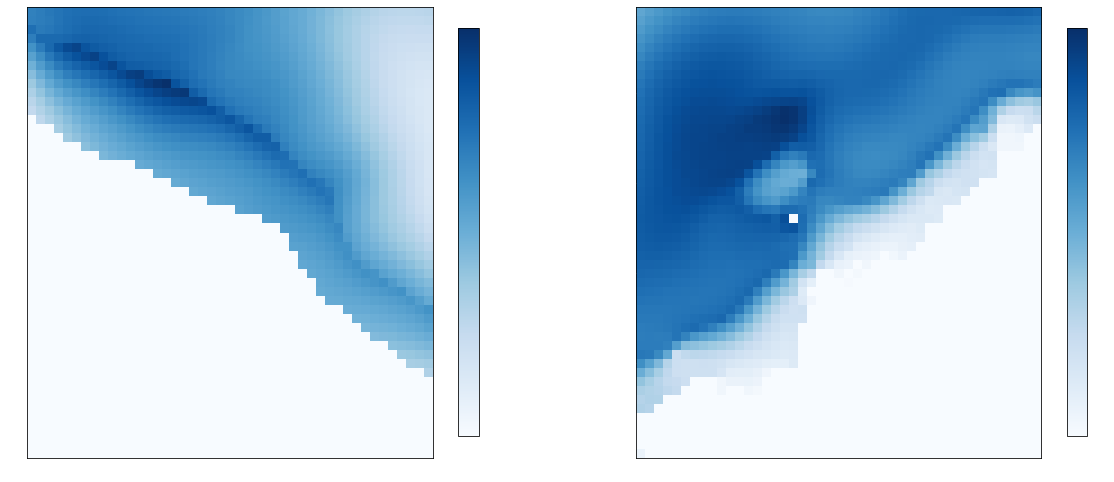

In [ ]:
eta0 = data_args["eta0"]

fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(eta0[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(eta0[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)


fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(eta0.data[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(eta0.data[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)

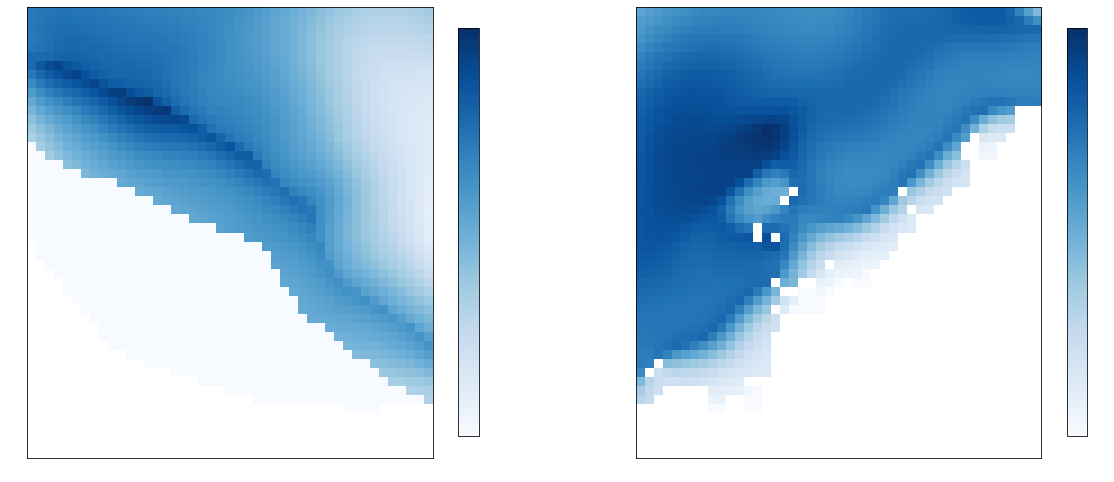

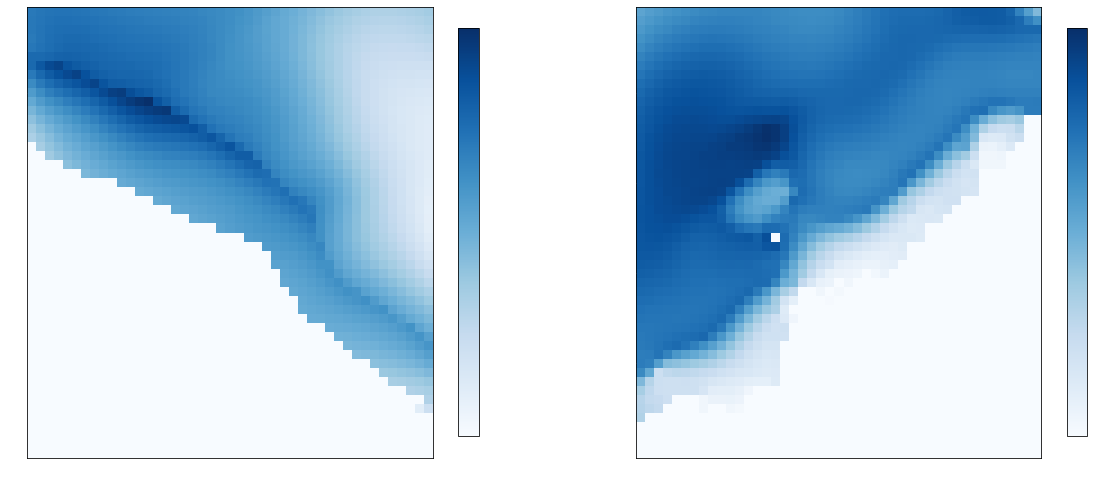

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(eta[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(eta[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)


fig, axs = plt.subplots(1,2, figsize=(20,15))
im0 = axs[0].imshow(eta.data[25:75,100:145], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im0, ax = axs[0], shrink=0.5)
im1 = axs[1].imshow(eta.data[0:50,330:375], origin="lower", cmap="Blues", vmin=0)
plt.colorbar(im1, ax = axs[1], shrink=0.5)
